## ewf-wfp-02-01-02 - Aggregated Land Surface Temperature Time Series

Aggregated Land Surface Temperature Time Series

---

### <a name="service">Service definition

In [1]:
service = dict([('title', 'Aggregated Land Surface Temperature Time Series'),
                ('abstract', 'Aggregated Land Surface Temperature Time Series'),
                ('id', 'ewf-wfp-02-01-02')])

### <a name="parameter">Parameter Definition 

In [2]:
N_1 = dict([('id', 'N_1'),
                          ('value', 'False'),
                          ('title', 'No Aggregation'),
                          ('abstract', 'No aggregation')])

In [3]:
N_3 = dict([('id', 'N_3'),
                          ('value', 'True'),
                          ('title', '30 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [4]:
N_6 = dict([('id', 'N_6'),
                          ('value', 'False'),
                          ('title', '60 Day Aggregation'),
                          ('abstract', 'Get a 30 day aggregation')])

In [5]:
 N_9 = dict([('id', 'N_9'),
                          ('value', 'False'),
                          ('title', '90 Day Aggregation'),
                          ('abstract', 'Get a 90 day aggregation')])

In [6]:
 N_12 = dict([('id', 'N_12'),
                          ('value', 'False'),
                          ('title', '120 Day Aggregation'),
                          ('abstract', 'Get a 120 day aggregation')])

In [7]:
 N_15 = dict([('id', 'N_15'),
                          ('value', 'False'),
                          ('title', '150 Day Aggregation'),
                          ('abstract', 'Get a 150 day aggregation')])

In [8]:
 N_18 = dict([('id', 'N_18'),
                          ('value', 'False'),
                          ('title', '180 Day Aggregation'),
                          ('abstract', 'Get a 180 day aggregation')])

In [9]:
 N_27 = dict([('id', 'N_27'),
                          ('value', 'False'),
                          ('title', '270 Day Aggregation'),
                          ('abstract', 'Get a 270 day aggregation')])

In [10]:
 N_36 = dict([('id', 'N_36'),
                          ('value', 'False'),
                          ('title', '360 Day Aggregation'),
                          ('abstract', 'Get a 360 day aggregation')])

In [11]:
regionOfInterest = dict([('id', 'regionOfInterest'),
                         ('value', 'POLYGON((11.5030755518998 -11.1141633706909,41.0343255518998 -11.1141633706909,41.0343255518998 -34.9763656693858,11.5030755518998 -34.9763656693858,11.5030755518998 -11.1141633706909))'),
                         ('title', 'WKT Polygon for the Region of Interest'),
                         ('abstract', 'Set the value of WKT Polygon')])

In [12]:
nameOfRegion = dict([('id', 'nameOfRegion'),
                     ('value', 'SouthernAfrica'),
                     ('title', 'Name of Region'),
                     ('abstract', 'Name of the region of interest'),
                     ('minOccurs', '1')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [13]:
# 2015
#input_identifiers = ('modis_lst_10d_2015-01-05.tif', 'modis_lst_10d_2015-01-15.tif', 'modis_lst_10d_2015-01-25.tif')

# 2016
#input_identifiers = ('modis_lst_10d_2016-01-05.tif', 'modis_lst_10d_2016-01-15.tif', 'modis_lst_10d_2016-01-25.tif')

# 2017
input_identifiers = ('modis_lst_10d_2017-01-05.tif', 'modis_lst_10d_2017-01-15.tif', 'modis_lst_10d_2017-01-25.tif')

**Input references**

This is the MODIS stack catalogue references

In [14]:
input_references = tuple(['https://catalog.terradue.com/modis/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [15]:
data_path = "/workspace/modis/outputs/output01"

**Aux folders**

In [16]:
output_folder = ''

In [17]:
temp_folder = 'temp'

#### Import Modules

In [18]:
import os
import shutil

import sys
import string
import numpy as np
from osgeo import gdal, ogr, osr
from shapely.wkt import loads

import datetime

import pdb

#### Auxiliary vars

In [19]:
check_results = False

#### Auxiliary methods

In [20]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)
            
#e.g. '2016-01-01'
def get_formatted_date(date_str):
    date = datetime.datetime.strftime(date_str, '%Y-%m-%dT00:00:00Z')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    first_date = get_formatted_date(first_date)
    last_date = get_formatted_date(last_date)
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))
            

def crop_image(input_image, polygon_wkt, output_path, product_type=None):
    
    dataset = None
    
    # creates directory if it doesnt exist yet
    crop_directory = os.path.dirname(output_path)
    if crop_directory is not '' and not os.path.exists(crop_directory):
        os.makedirs(crop_directory)
        
    
    if input_image.startswith('ftp://') or input_image.startswith('http'):
        try:
            dataset = gdal.Open('/vsigzip//vsicurl/%s' % input_image)
        except Exception as e:
            print(e)
    elif '.nc' in input_image:
        dataset = gdal.Open('NETCDF:' + input_image + ':' + product_type)
        
    else: # .tif
        dataset = gdal.Open(input_image)
        
    
    no_data_value = dataset.GetRasterBand(1).GetNoDataValue()
    geo_t = dataset.GetGeoTransform()
    polygon_ogr = ogr.CreateGeometryFromWkt(polygon_wkt)
    envelope = polygon_ogr.GetEnvelope()
    bounds = [envelope[0], envelope[2], envelope[1], envelope[3]]
    gdal.Warp(output_path, dataset, format="GTiff", outputBoundsSRS='EPSG:4326', outputBounds=bounds, srcNodata=no_data_value, dstNodata=no_data_value, xRes=geo_t[1], yRes=-geo_t[5], targetAlignedPixels=True)
    

    
def write_output_image(filepath, output_matrix, image_format, data_format, mask=None, output_projection=None, output_geotransform=None, no_data_value=None):
    
    driver = gdal.GetDriverByName(image_format)
    out_rows = np.size(output_matrix, 0)
    out_columns = np.size(output_matrix, 1)
    
    
    if mask is not None and mask is not 0:
        # TODO: check if output folder exists
        output = driver.Create(filepath, out_columns, out_rows, 2, data_format)
        mask_band = output.GetRasterBand(2)
        mask_band.WriteArray(mask)
        if no_data_value is not None:
            output_matrix[mask > 0] = no_data_value
    else:
        output = driver.Create(filepath, out_columns, out_rows, 1, data_format)
    
    if output_projection is not None:
        output.SetProjection(output_projection)
    if output_geotransform is not None:
        output.SetGeoTransform(output_geotransform)
    
    raster_band = output.GetRasterBand(1)
    if no_data_value is not None:
        raster_band.SetNoDataValue(no_data_value)
    raster_band.WriteArray(output_matrix)
    
    gdal.Warp(filepath, output, format="GTiff", outputBoundsSRS='EPSG:4326', xRes=output_geotransform[1], yRes=-output_geotransform[5], targetAlignedPixels=True)



    
def calc_max_matrix(mat1, mat2, no_data_value=None):
    
    if no_data_value is not None:
        if not isinstance(mat1, int):
            mat1[(mat1 == no_data_value)] = 0
        if not isinstance(mat2, int):
            mat2[(mat2 == no_data_value)] = 0
    
    return np.where(mat1 > mat2, mat1, mat2)


def matrix_sum(mat1, mat2, no_data_value=None):
    if no_data_value is not None:
        if not isinstance(mat1, int):
            mat1[(mat1 == no_data_value)] = 0
        if not isinstance(mat2, int):
            mat2[(mat2 == no_data_value)] = 0
            
            
    msum = mat1 + mat2
        
    msum[(mat1 == 0)] = 0
    msum[(mat2 == 0)] = 0
        
    return msum
            
            
    #return mat1 + mat2

def calc_average(matrix_list, n_matrix, no_data_value=None):
    if not matrix_list:
        return 0
    result = matrix_list[0]
    for i in range(1, n_matrix):
        result = matrix_sum(result, matrix_list[i], no_data_value)
    
    return np.divide(result, (n_matrix*1.00))

def get_matrix_list(image_list):
    mat_list = []
    for img in image_list:
        dataset = gdal.Open(img)
        product_array = dataset.GetRasterBand(1).ReadAsArray()
        mat_list.append(product_array)
        dataset = None
    return mat_list



def calc_aggregations(product_list, N_value, region_of_interest, product_type):
    mask_no_data_value = 0
    max_values = 0
    averages = 0
    temp_list = []
    no_data_value = None
    
    print(type(product_list))
    
    for product_url in product_list:
        
        # uncompressed data
        product = product_url.split('/')[-1]
        print(product)
        
        
        
        cropped_product_path = temp_folder + '/' + 'crop_' + product
        #cropped_product_path = cropped_product_path.split('.nc')[0] + '.tif'
        try:
            
            
            crop_image(product_url, region_of_interest, cropped_product_path, product_type)
            
            #pdb.set_trace()
            
            # Read GeoTIFF as an array
            dataset = gdal.Open(cropped_product_path)
            #pdb.set_trace()
            product_array = dataset.GetRasterBand(1).ReadAsArray()
            no_data_value = dataset.GetRasterBand(1).GetNoDataValue()
            print(no_data_value)
            geo_transform = dataset.GetGeoTransform()
            projection = dataset.GetProjection()
            ## Create mask of no_data_values
            if no_data_value is not None:
                if isinstance(mask_no_data_value, int):
                    mask_no_data_value = np.where(product_array == no_data_value, 1, 0)
                else:
                    temp_mask = np.where(product_array == no_data_value, 1, 0)
                    mask_no_data_value = matrix_sum(mask_no_data_value, temp_mask)
            max_values = calc_max_matrix(max_values, product_array, no_data_value)
            temp_list.append(product_array)
            dataset = None
            
        except Exception as e:
            print('Error processing the product ' + product + ': ' + str(e))
        if os.path.exists(cropped_product_path):
            os.remove(cropped_product_path)
    
    averages = calc_average(temp_list, N_value, no_data_value)
    
    return max_values, averages, mask_no_data_value, geo_transform, projection, no_data_value




def write_outputs(product_name, roi_name, first_date, last_date, averages, max_values, mask_no_data_value, image_format, product_count, projection, geo_transform, no_data_value):
    filenames = []
    filenames.append(product_name + '_' + roi_name + '_N' + str(product_count) + '_averages_' + first_date + '_' + last_date + '.tif')
    filenames.append(product_name + '_' + roi_name + '_N' + str(product_count) + '_maxvalues_' + first_date + '_' + last_date + '.tif')
    
    #pdb.set_trace()
    
    #GDT_UInt16
    
    #write_output_image(filenames[0], averages, image_format,  gdal.GDT_Byte, mask_no_data_value, projection, geo_transform, no_data_value)
    #write_output_image(filenames[1], max_values, image_format, gdal.GDT_Byte, mask_no_data_value, projection, geo_transform, no_data_value)
    
    mask_no_data_value = None # Temp
    write_output_image(filenames[0], averages, image_format,  gdal.GDT_UInt16, mask_no_data_value, projection, geo_transform, no_data_value)
    write_output_image(filenames[1], max_values, image_format, gdal.GDT_UInt16, mask_no_data_value, projection, geo_transform, no_data_value)
    
    return filenames

In [21]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Workflow

Compute Aggregations

In [22]:
if isinstance(input_references, str):
    input_references = [input_references]

region_of_interest = regionOfInterest['value']
name_of_region = nameOfRegion['value']


#first_date = '2017-01-01'
#last_date = '2017-01-21'

first_date = os.path.splitext(os.path.basename(input_identifiers[0]))[0].split('_')[-1]
last_date = os.path.splitext(os.path.basename(input_identifiers[-1]))[0].split('_')[-1]

print(first_date)
print(last_date)

#first_date = '2017-01-01'
#last_date = '2017-01-21'

#print(first_date)
#print(last_date)


# N time steps
nlist = [N_1['value'], N_3['value'], N_6['value'], N_9['value'], N_12['value'], N_15['value'], N_18['value'], N_27['value'], N_36['value']]
nlist = [n == 'True' for n in nlist]
nvalues = [1, 3, 6, 9, 12, 15, 18, 27, 36]

# list of files


for bl,nv in zip(nlist, nvalues):
    
    # only works for selected N time steps
    if bl:
        
        # works only if N and number of given images match
        if nv == len(input_identifiers):
            
            N = nv
            
            # list of files with full path
            file_list = [data_path + '/' + file_name for file_name in input_identifiers]
        
            print(file_list)

            max_values, averages, no_value, geo_transform, projection, no_data = calc_aggregations(file_list, N, region_of_interest, None)
            
            print(averages)
            
        else:
            
            print("N value and number of images don't match")
            
            
            

2017-01-05
2017-01-25
['/workspace/modis/outputs/output01/modis_lst_10d_2017-01-05.tif', '/workspace/modis/outputs/output01/modis_lst_10d_2017-01-15.tif', '/workspace/modis/outputs/output01/modis_lst_10d_2017-01-25.tif']
<type 'list'>
modis_lst_10d_2017-01-05.tif
0.0
modis_lst_10d_2017-01-15.tif
0.0
modis_lst_10d_2017-01-25.tif
0.0
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [23]:

# CHECK
if check_results:
    import matplotlib
    import matplotlib.pyplot as plt

    fig = plt.figure()
    plt.imshow(averages)
    plt.show()

<Figure size 640x480 with 1 Axes>

In [24]:
averages[300,200]

15573.333333333334

In [25]:

# CHECK

# import georasters

# Load data
#raster = temp_folder + '/' + 'crop_regtdt201701d1.tif'
#data = georasters.from_file(raster)

# Plot data
#data.plot()

Saves Aggregations to Geotiffs

In [26]:

#product_path_name = output_folder + '/' + 'LST'

product_path_name = os.path.join(output_folder, 'LST' )

#type(product_path_name)

filenames = write_outputs(product_path_name, name_of_region, first_date, last_date, averages, max_values, no_value, 'GTiff', N, projection, geo_transform, no_data)

# TODO
#write_properties_file(interval_gpd, output_name)

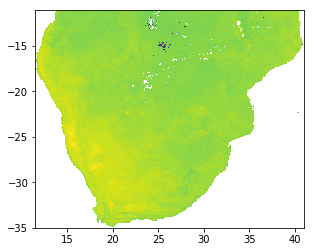

In [27]:
# CHECK
if check_results:

    import rasterio

    from rasterio.plot import show

    # Load data
    #raster = output_folder + '/' + 'LST_SouthernAfrica_N3_maxvalues_'+first_date+'_'+last_date+'.tif'
    raster = filenames[0]
    data = rasterio.open(raster)

    show(data)

    #data = georasters.from_file(raster)

    # Plot data
    #data.plot()

    #print(no_data)


#### write properties files

In [28]:
for output_name in filenames:
    
    write_properties_file(output_name, datetime.datetime.strptime(first_date, "%Y-%m-%d").date(), datetime.datetime.strptime(last_date, "%Y-%m-%d").date(), region_of_interest)
    

#### Remove temporay files and folders

In [29]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)